<a href="https://colab.research.google.com/github/Mamiglia/challenge/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !mkdir data
# !gdown 1CVAQDuPOiwm8h9LJ8a_oOs6zOWS6EgkB
# !gdown 1ykZ9fjTxUwdiEwqagoYZiMcD5aG-7rHe
# !unzip -o test.zip -d data
# !unzip -o train.zip -d data

# !git clone https://github.com/Mamiglia/challenge.git

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm
import math
import torch.nn.functional as F 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from src.common import load_data, prepare_train_data, generate_submission

In [3]:
# Configuration
MODEL_PATH = "models/mlp_baseline.pth"
EPOCHS = 20
BATCH_SIZE = 128
LR = 1e-4

DEVICE = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: mps


In [4]:
class KernelAdapter(nn.Module):
    """Base kernel adapter with Random Fourier Features"""
    def __init__(self, d_in, d_out, n_feats=256, sigma=0.8, dropout=0.1):
        super().__init__()
        self.W = nn.Parameter(torch.randn(d_in, n_feats) / sigma)
        self.b = nn.Parameter(torch.rand(n_feats) * 2 * math.pi)
        self.fc = nn.Linear(n_feats, d_out)
        self.drop = nn.Dropout(dropout)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        x_proj = torch.cos(x @ self.W + self.b)
        x_proj = self.drop(x_proj)
        out = self.fc(x_proj)
        return F.normalize(out, dim=-1)


class KernelResidualAdapter(nn.Module):
    """Kernel adapter + residual MLP + local geometric correction"""
    def __init__(self, d_in=1024, d_out=1536, n_feats=512, sigma=0.7):
        super().__init__()
        self.kernel = KernelAdapter(d_in, d_out, n_feats, sigma)
        self.residual = nn.Sequential(
            nn.Linear(d_in, d_out),
            nn.GELU(),
            nn.Linear(d_out, d_out)
        )
        # Local geometric correction (small feature-wise modulation)
        self.local = nn.Sequential(
            nn.Linear(d_in, d_out // 8),
            nn.GELU(),
            nn.Linear(d_out // 8, d_out),
            nn.Tanh()
        )

        # Amplitude scaling gate
        self.scale = nn.Sequential(
            nn.Linear(d_in, d_out),
            nn.Sigmoid()
        )

        # 🔹 Affine alignment layer (Procrustes-like)
        self.align = nn.Linear(d_out, d_out, bias=False)
        nn.init.eye_(self.align.weight)  # inizializza come identità

    def forward(self, x):
        base = self.kernel(x)
        res = self.residual(x)
        local = self.local(x) * 0.3  # local correction term (scaled)
        scale = self.scale(x)

        # composizione finale
        out = (base + 0.5 * res + local) * scale
        out = self.align(out)  # affine rotation layer

        # normalizzazione su sfera unitaria
        # return F.normalize(out, dim=-1)
        return out

In [5]:
def hybrid_loss(z_pred, z_true, temperature=0.15, alpha=0.2, beta=0.6, gamma=1.5, hard_neg_weight=0.1):
    # === Allineamento direzionale ===
    mse = F.mse_loss(z_pred, z_true)
    cos = 1 - F.cosine_similarity(z_pred, z_true, dim=-1).mean()

    # === InfoNCE standard ===
    z_pred = F.normalize(z_pred, dim=-1)
    z_true = F.normalize(z_true, dim=-1)
    logits = (z_pred @ z_true.T) / temperature
    labels = torch.arange(logits.size(0), device=z_pred.device)
    contrast = F.cross_entropy(logits, labels)

    # === Penalizzazione hard negatives (solo nei logits “vicini”) ===
    with torch.no_grad():
        mask_pos = torch.eye(logits.size(0), device=logits.device).bool()
        logits_neg = logits.masked_fill(mask_pos, -1e-9)
        sim_ranks = logits_neg.topk(k=5, dim=1).indices
    hard_mask = torch.zeros_like(logits)
    hard_mask.scatter_(1, sim_ranks, 1.0)
    hard_neg = torch.log1p((hard_mask * torch.exp(logits_neg)).sum(1)).mean()

    return alpha*mse + beta*cos + gamma*contrast + hard_neg_weight * hard_neg

def align_uniform_loss(z1, z2, alpha=2, lam=0.1):
    # alignment: rendi vicini i positivi
    align = (z1 - z2).pow(2).sum(1).pow(alpha / 2).mean()

    # uniformity: calcolo manuale delle distanze
    z1 = F.normalize(z1, dim=-1)
    sim_matrix = z1 @ z1.T
    sq_dist = 2 - 2 * sim_matrix  # ||x_i - x_j||^2 = 2(1 - cos)
    uniform = torch.log(torch.exp(-lam * sq_dist).mean())
    
    return align + uniform


In [6]:
def metric_reg(z_pred, z_text, k=30):
    """Forza coerenza locale tra spazi: se due caption sono simili in A, lo siano anche in B."""
    with torch.no_grad():
        sims_text = (z_text @ z_text.T)
        idx = sims_text.topk(k, dim=1).indices
        mask = torch.zeros_like(sims_text)
        mask.scatter_(1, idx, 1.0)
    sims_pred = (z_pred @ z_pred.T)
    return ((mask * (sims_pred - sims_text))**2).mean()

def relational_alignment_loss(z_pred, S_target, max_points=512):
    """
    Encourage predicted space to preserve the target (VAE) relational geometry.
    S_target: precomputed [M, M] similarity matrix (subset used automatically)
    """
    N = z_pred.shape[0]
    M = S_target.shape[0]

    # Se batch più grande della matrice target, usa solo primi punti
    if N > M:
        z_pred = z_pred[:M]
        N = M

    # Estrai un sottoinsieme coerente da S_target (prima N righe e colonne)
    S_sub = S_target[:N, :N].to(z_pred.device)

    # Calcola struttura predetta
    z_pred = F.normalize(z_pred, dim=-1)
    S_pred = z_pred @ z_pred.T  # [N, N]

    # MSE fra le due strutture
    loss = F.mse_loss(S_pred, S_sub)
    return loss



In [7]:
def compute_geodesic_similarity(Y, scale=0.5, max_points=2000):
    """
    Compute geodesic similarity with automatic sigma adaptation.

    scale: multiplicative factor to adjust sigma relative to mean distance.
           smaller -> more contrast, larger -> smoother.
    """
    if len(Y) > max_points:
        idx = torch.randperm(len(Y))[:max_points]
        Y = Y[idx]

    # Pairwise distances
    dist2 = torch.cdist(Y, Y, p=2).pow(2)
    mean_d2 = dist2.mean().item()
    sigma = (mean_d2 ** 0.5) * scale   # e.g. 0.5 × mean distance
    print(f"[auto-sigma] mean distance²={mean_d2:.4f}, sigma={sigma:.4f}")

    S = torch.exp(-dist2 / (2 * sigma**2))
    S = S / S.max()
    return S



In [8]:
def compute_text_similarity(X, max_points=2000):
    if len(X) > max_points:
        idx = torch.randperm(len(X))[:max_points]
        X = X[idx]
    S = (F.cosine_similarity(X.unsqueeze(1), X.unsqueeze(0), dim=-1) + 1) / 2
    return S

In [9]:
def parallel_transport_loss(z_pred, z_text):
    if z_text.size(0) < 2:
        return torch.tensor(0.0, device=z_pred.device)
    dz = z_text[1:] - z_text[:-1]
    dp = z_pred[1:] - z_pred[:-1]
    dz = F.normalize(dz, dim=-1)
    dp = F.normalize(dp, dim=-1)
    # riduci alla dimensione minima comune
    d = min(dz.shape[-1], dp.shape[-1])
    dz, dp = dz[..., :d], dp[..., :d]
    return 1 - F.cosine_similarity(dp, dz, dim=-1).mean()


In [10]:
def train_model(model, train_loader, val_loader, device, epochs, lr, S_vae):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-4,
    epochs=epochs,
    steps_per_epoch=len(train_loader)
)


    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            outputs = model(X_batch)

            # === Loss composita ===
            loss = (
                hybrid_loss(outputs, y_batch)
                + 0.2 * metric_reg(outputs, y_batch)
                + 0.1 * align_uniform_loss(outputs, y_batch)
                + 0.3 * relational_alignment_loss(outputs, S_vae)
                + 0.05 * parallel_transport_loss(outputs, X_batch)
            )

            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # === Validation ===
        model.eval()
        val_loss, cos_sim, mse, contrastive = 0, 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = (
                    hybrid_loss(outputs, y_batch)
                    + 0.2 * metric_reg(outputs, y_batch)
                    + 0.1 * align_uniform_loss(outputs, y_batch)
                    + 0.3 * relational_alignment_loss(outputs, S_vae)
                    + 0.05 * parallel_transport_loss(outputs, X_batch)
                )
                val_loss += loss.item()
                cos_sim += F.cosine_similarity(outputs, y_batch, dim=-1).mean().item()
                mse += F.mse_loss(outputs, y_batch).item()
                sim = (F.normalize(outputs, dim=-1) @ F.normalize(y_batch, dim=-1).T)
                pos = torch.arange(sim.size(0), device=device)
                contrastive += F.cross_entropy(sim / 0.15, pos).item()

        n_batches = len(val_loader)
        val_loss /= n_batches
        cos_sim /= n_batches
        mse /= n_batches
        contrastive /= n_batches

        print(f"Cosine={cos_sim:.4f}, MSE={mse:.4f}, Contrastive={contrastive:.4f}")
        print(
            f"Epoch {epoch+1}: "
            f"TrainLoss={train_loss:.4f}, ValLoss={val_loss:.4f} | "
            f"MSE={mse:.4f}, Cosine={cos_sim:.4f}, Contrastive={contrastive:.4f}, "
            f"MetricReg={metric_reg(outputs, y_batch):.4f}, "
            f"AlignUniform={align_uniform_loss(outputs, y_batch):.4f}, "
            f"Relational={relational_alignment_loss(outputs, S_vae):.4f}, "
            f"PT={parallel_transport_loss(outputs, X_batch):.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best model (val_loss={val_loss:.6f})")

    return model


In [11]:
def whiten(X, eps=1e-6):
    X = X - X.mean(0, keepdim=True)
    cov = (X.T @ X) / (X.shape[0] - 1)
    eigvals, eigvecs = torch.linalg.eigh(cov)
    
    # Evita divisione per 0
    eigvals = torch.clamp(eigvals, min=eps)
    
    W = eigvecs @ torch.diag(1.0 / torch.sqrt(eigvals)) @ eigvecs.T
    return X @ W

# SVD VERSION 
# def whiten(X, eps=1e-6):
#     """
#     Whiten data matrix X using SVD decomposition (numerically stable).

#     Args:
#         X (torch.Tensor): input data of shape [N, D]
#         eps (float): small constant for numerical stability
#     Returns:
#         torch.Tensor: whitened data of shape [N, D]
#     """
#     # 1️⃣ Center the data (remove mean)
#     X = X - X.mean(0, keepdim=True)
    
#     # 2️⃣ Compute SVD (does not require explicit covariance)
#     # X = U * S * Vh, where columns of Vh are principal directions
#     U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    
#     # 3️⃣ Scale by inverse sqrt of singular values
#     # (equivalent to dividing by std in each PCA direction)
#     X_white = (U @ torch.diag(1.0 / torch.sqrt(S + eps))) @ Vh
    
#     # 4️⃣ Optional: normalize each vector to unit norm
#     X_white = F.normalize(X_white, dim=-1)
    
#     return X_white

(125000,)
Train data: 125000 captions, 125000 images
[auto-sigma] mean distance²=589.6943, sigma=12.1418
Computed S_vae with shape: torch.Size([2000, 2000])


Computed S_text with shape: torch.Size([512, 512])


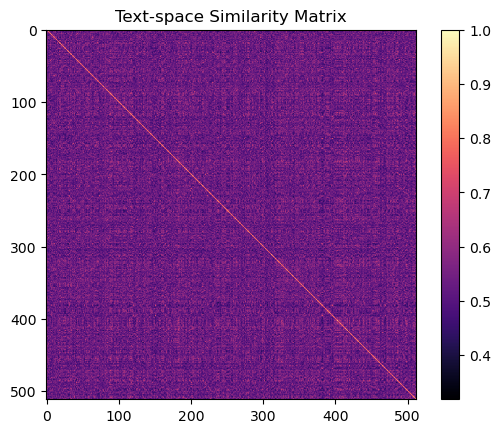

(1536, 1024)

In [12]:
# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)

S_vae = compute_geodesic_similarity(y, scale=0.5)
print("Computed S_vae with shape:", S_vae.shape)
plt.imshow(S_vae.cpu().numpy(), cmap='magma')
plt.title("Approx. Geodesic Similarity (VAE latent space)")
plt.colorbar()
plt.show()

# X = whiten(X)
# y = whiten(y)
X = F.normalize(X, dim=-1)
y = F.normalize(y, dim=-1)


# === Approximate Similarity in the Text Embedding Space ===
S_text = compute_text_similarity(X, 512)
print("Computed S_text with shape:", S_text.shape)
plt.imshow(S_text.cpu().numpy(), cmap='magma')
plt.title("Text-space Similarity Matrix")
plt.colorbar()
plt.show()

DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
y_train.shape[-1], X_val.shape[-1]

In [13]:
model = KernelResidualAdapter().to(DEVICE)
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
print("\n3. Training...")
model = train_model(model, train_loader, val_loader, DEVICE, EPOCHS, LR, S_vae)

# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH))

   Parameters: 9,674,944

3. Training...


Epoch 1/20: 100%|██████████| 879/879 [00:35<00:00, 24.73it/s]


Cosine=0.4685, MSE=0.0006, Contrastive=3.5473
Epoch 1: TrainLoss=6.7797, ValLoss=6.2762 | MSE=0.0006, Cosine=0.4685, Contrastive=3.5473, MetricReg=0.1104, AlignUniform=0.7362, Relational=0.0656, PT=0.9908
  ✓ Saved best model (val_loss=6.276196)


Epoch 2/20: 100%|██████████| 879/879 [00:35<00:00, 25.02it/s]


Cosine=0.4729, MSE=0.0005, Contrastive=3.3443
Epoch 2: TrainLoss=5.8557, ValLoss=5.9576 | MSE=0.0005, Cosine=0.4729, Contrastive=3.3443, MetricReg=0.1301, AlignUniform=0.6606, Relational=0.0632, PT=0.9818
  ✓ Saved best model (val_loss=5.957645)


Epoch 3/20: 100%|██████████| 879/879 [00:35<00:00, 25.07it/s]


Cosine=0.4700, MSE=0.0005, Contrastive=3.2793
Epoch 3: TrainLoss=5.5948, ValLoss=5.8574 | MSE=0.0005, Cosine=0.4700, Contrastive=3.2793, MetricReg=0.1374, AlignUniform=0.6505, Relational=0.0597, PT=0.9812
  ✓ Saved best model (val_loss=5.857375)


Epoch 4/20: 100%|██████████| 879/879 [00:34<00:00, 25.19it/s]


Cosine=0.4774, MSE=0.0005, Contrastive=3.2557
Epoch 4: TrainLoss=5.4880, ValLoss=5.8213 | MSE=0.0005, Cosine=0.4774, Contrastive=3.2557, MetricReg=0.1307, AlignUniform=0.6800, Relational=0.0565, PT=0.9818
  ✓ Saved best model (val_loss=5.821251)


Epoch 5/20: 100%|██████████| 879/879 [00:34<00:00, 25.21it/s]


Cosine=0.4775, MSE=0.0006, Contrastive=3.2222
Epoch 5: TrainLoss=5.4163, ValLoss=5.7734 | MSE=0.0006, Cosine=0.4775, Contrastive=3.2222, MetricReg=0.1247, AlignUniform=0.7084, Relational=0.0558, PT=0.9817
  ✓ Saved best model (val_loss=5.773437)


Epoch 6/20: 100%|██████████| 879/879 [00:34<00:00, 25.13it/s]


Cosine=0.4747, MSE=0.0006, Contrastive=3.1951
Epoch 6: TrainLoss=5.3382, ValLoss=5.7329 | MSE=0.0006, Cosine=0.4747, Contrastive=3.1951, MetricReg=0.1264, AlignUniform=0.7280, Relational=0.0569, PT=0.9836
  ✓ Saved best model (val_loss=5.732877)


Epoch 7/20: 100%|██████████| 879/879 [00:35<00:00, 24.83it/s]


Cosine=0.4746, MSE=0.0006, Contrastive=3.1691
Epoch 7: TrainLoss=5.2555, ValLoss=5.6934 | MSE=0.0006, Cosine=0.4746, Contrastive=3.1691, MetricReg=0.1301, AlignUniform=0.7270, Relational=0.0578, PT=0.9832
  ✓ Saved best model (val_loss=5.693392)


Epoch 8/20: 100%|██████████| 879/879 [00:35<00:00, 24.52it/s]


Cosine=0.4836, MSE=0.0006, Contrastive=3.1528
Epoch 8: TrainLoss=5.1769, ValLoss=5.6679 | MSE=0.0006, Cosine=0.4836, Contrastive=3.1528, MetricReg=0.1357, AlignUniform=0.7271, Relational=0.0577, PT=0.9845
  ✓ Saved best model (val_loss=5.667892)


Epoch 9/20: 100%|██████████| 879/879 [00:35<00:00, 24.81it/s]


Cosine=0.4852, MSE=0.0005, Contrastive=3.1370
Epoch 9: TrainLoss=5.1055, ValLoss=5.6429 | MSE=0.0005, Cosine=0.4852, Contrastive=3.1370, MetricReg=0.1372, AlignUniform=0.6954, Relational=0.0538, PT=0.9853
  ✓ Saved best model (val_loss=5.642853)


Epoch 10/20: 100%|██████████| 879/879 [00:35<00:00, 24.87it/s]


Cosine=0.4809, MSE=0.0005, Contrastive=3.1258
Epoch 10: TrainLoss=5.0404, ValLoss=5.6248 | MSE=0.0005, Cosine=0.4809, Contrastive=3.1258, MetricReg=0.1423, AlignUniform=0.6845, Relational=0.0526, PT=0.9829
  ✓ Saved best model (val_loss=5.624786)


Epoch 11/20: 100%|██████████| 879/879 [00:35<00:00, 24.52it/s]


Cosine=0.4765, MSE=0.0005, Contrastive=3.1196
Epoch 11: TrainLoss=4.9785, ValLoss=5.6158 | MSE=0.0005, Cosine=0.4765, Contrastive=3.1196, MetricReg=0.1435, AlignUniform=0.6903, Relational=0.0538, PT=0.9821
  ✓ Saved best model (val_loss=5.615776)


Epoch 12/20: 100%|██████████| 879/879 [00:35<00:00, 25.07it/s]


Cosine=0.4728, MSE=0.0005, Contrastive=3.1158
Epoch 12: TrainLoss=4.9205, ValLoss=5.6095 | MSE=0.0005, Cosine=0.4728, Contrastive=3.1158, MetricReg=0.1469, AlignUniform=0.6903, Relational=0.0548, PT=0.9834
  ✓ Saved best model (val_loss=5.609547)


Epoch 13/20: 100%|██████████| 879/879 [00:35<00:00, 24.97it/s]


Cosine=0.4735, MSE=0.0005, Contrastive=3.1142
Epoch 13: TrainLoss=4.8654, ValLoss=5.6061 | MSE=0.0005, Cosine=0.4735, Contrastive=3.1142, MetricReg=0.1493, AlignUniform=0.6765, Relational=0.0546, PT=0.9824
  ✓ Saved best model (val_loss=5.606076)


Epoch 14/20: 100%|██████████| 879/879 [00:35<00:00, 25.08it/s]


Cosine=0.4690, MSE=0.0005, Contrastive=3.1126
Epoch 14: TrainLoss=4.8132, ValLoss=5.6036 | MSE=0.0005, Cosine=0.4690, Contrastive=3.1126, MetricReg=0.1522, AlignUniform=0.6724, Relational=0.0538, PT=0.9841
  ✓ Saved best model (val_loss=5.603601)


Epoch 15/20: 100%|██████████| 879/879 [00:35<00:00, 24.90it/s]


Cosine=0.4657, MSE=0.0005, Contrastive=3.1140
Epoch 15: TrainLoss=4.7663, ValLoss=5.6054 | MSE=0.0005, Cosine=0.4657, Contrastive=3.1140, MetricReg=0.1559, AlignUniform=0.6617, Relational=0.0508, PT=0.9839


Epoch 16/20: 100%|██████████| 879/879 [00:35<00:00, 24.97it/s]


Cosine=0.4635, MSE=0.0005, Contrastive=3.1141
Epoch 16: TrainLoss=4.7255, ValLoss=5.6054 | MSE=0.0005, Cosine=0.4635, Contrastive=3.1141, MetricReg=0.1582, AlignUniform=0.6575, Relational=0.0524, PT=0.9829


Epoch 17/20: 100%|██████████| 879/879 [00:35<00:00, 25.02it/s]


Cosine=0.4624, MSE=0.0005, Contrastive=3.1163
Epoch 17: TrainLoss=4.6903, ValLoss=5.6086 | MSE=0.0005, Cosine=0.4624, Contrastive=3.1163, MetricReg=0.1604, AlignUniform=0.6557, Relational=0.0522, PT=0.9824


Epoch 18/20: 100%|██████████| 879/879 [00:36<00:00, 23.89it/s]


Cosine=0.4605, MSE=0.0005, Contrastive=3.1178
Epoch 18: TrainLoss=4.6637, ValLoss=5.6110 | MSE=0.0005, Cosine=0.4605, Contrastive=3.1178, MetricReg=0.1615, AlignUniform=0.6554, Relational=0.0526, PT=0.9829


Epoch 19/20: 100%|██████████| 879/879 [00:35<00:00, 24.69it/s]


Cosine=0.4584, MSE=0.0005, Contrastive=3.1184
Epoch 19: TrainLoss=4.6455, ValLoss=5.6120 | MSE=0.0005, Cosine=0.4584, Contrastive=3.1184, MetricReg=0.1620, AlignUniform=0.6564, Relational=0.0523, PT=0.9828


Epoch 20/20: 100%|██████████| 879/879 [00:35<00:00, 24.94it/s]


Cosine=0.4586, MSE=0.0005, Contrastive=3.1188
Epoch 20: TrainLoss=4.6360, ValLoss=5.6125 | MSE=0.0005, Cosine=0.4586, Contrastive=3.1188, MetricReg=0.1622, AlignUniform=0.6562, Relational=0.0522, PT=0.9827


<All keys matched successfully>

## Evaluation

### Visualize

In [14]:


def visualize_latent_space(model, X_val, y_val, device, method="pca", n_samples=2000):
    model.eval()
    with torch.no_grad():
        X_val = X_val[:n_samples].to(device)
        y_val = y_val[:n_samples].to(device)
        z_pred = model(X_val).cpu()
        z_true = y_val.cpu()

    if method == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, init="pca")
    else:
        reducer = PCA(n_components=2)

    z_pred_2d = reducer.fit_transform(z_pred)
    z_true_2d = reducer.fit_transform(z_true)

    plt.figure(figsize=(8, 6))
    plt.scatter(z_true_2d[:, 0], z_true_2d[:, 1], alpha=0.5, s=12, label="True (Target Space)")
    plt.scatter(z_pred_2d[:, 0], z_pred_2d[:, 1], alpha=0.5, s=12, label="Predicted (Mapped Space)")
    plt.title(f"Latent Space Visualization ({method.upper()})")
    plt.legend()
    plt.show()


def visualize_tsne(model, X_val, y_val, device, n_samples=2000, perplexity=30, seed=42):
    """
    Visualizza le embedding predette e target nello spazio 2D con t-SNE.
    """
    model.eval()
    with torch.no_grad():
        X_val = X_val[:n_samples].to(device)
        y_val = y_val[:n_samples].to(device)
        z_pred = F.normalize(model(X_val), dim=-1).cpu().numpy()
        z_true = F.normalize(y_val, dim=-1).cpu().numpy()

    # Concatena per ottenere embedding congiunte
    Z = np.concatenate([z_pred, z_true], axis=0)
    labels = np.array([0] * len(z_pred) + [1] * len(z_true))  # 0=pred, 1=true

    # Riduzione con t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=1000,
        init="pca",
        learning_rate="auto",
        random_state=seed,
        verbose=1
    )
    Z_2d = tsne.fit_transform(Z)

    # Split per colore
    Z_pred_2d = Z_2d[labels == 0]
    Z_true_2d = Z_2d[labels == 1]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(Z_true_2d[:, 0], Z_true_2d[:, 1],
                alpha=0.45, s=18, c="#1f77b4", label="True (target space)")
    plt.scatter(Z_pred_2d[:, 0], Z_pred_2d[:, 1],
                alpha=0.45, s=18, c="#ff7f0e", label="Predicted (mapped space)")
    plt.title(f"t-SNE of Predicted vs True Embeddings ({n_samples} samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [15]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn.functional as F

def visualize_latent_space_3d(model, X_val, y_val, device, n_samples=2000, method="pca"):
    """
    Visualizza gli embedding predetti e target in 3D (interattivo) con Plotly.
    """
    model.eval()
    with torch.no_grad():
        X_val = X_val[:n_samples].to(device)
        y_val = y_val[:n_samples].to(device)
        z_pred = F.normalize(model(X_val), dim=-1).cpu().numpy()
        z_true = F.normalize(y_val, dim=-1).cpu().numpy()

    # Riduzione dimensionale (3D)
    if method == "tsne":
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=3, perplexity=30, n_iter=1000, init="pca", learning_rate="auto")
        Z_pred = reducer.fit_transform(z_pred)
        Z_true = reducer.fit_transform(z_true)
    else:
        reducer = PCA(n_components=3)
        Z_pred = reducer.fit_transform(z_pred)
        Z_true = reducer.fit_transform(z_true)

    # Creazione grafico interattivo
    fig = go.Figure()

    # Target space
    fig.add_trace(go.Scatter3d(
        x=Z_true[:,0], y=Z_true[:,1], z=Z_true[:,2],
        mode='markers',
        marker=dict(size=3, color='royalblue', opacity=0.6),
        name='True (Target Space)'
    ))

    # Predicted space
    fig.add_trace(go.Scatter3d(
        x=Z_pred[:,0], y=Z_pred[:,1], z=Z_pred[:,2],
        mode='markers',
        marker=dict(size=3, color='orange', opacity=0.6),
        name='Predicted (Mapped Space)'
    ))

    fig.update_layout(
        title=f"3D Latent Space Visualization ({method.upper()})",
        scene=dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3'
        ),
        width=850,
        height=700,
        legend=dict(x=0.02, y=0.98)
    )

    fig.show()


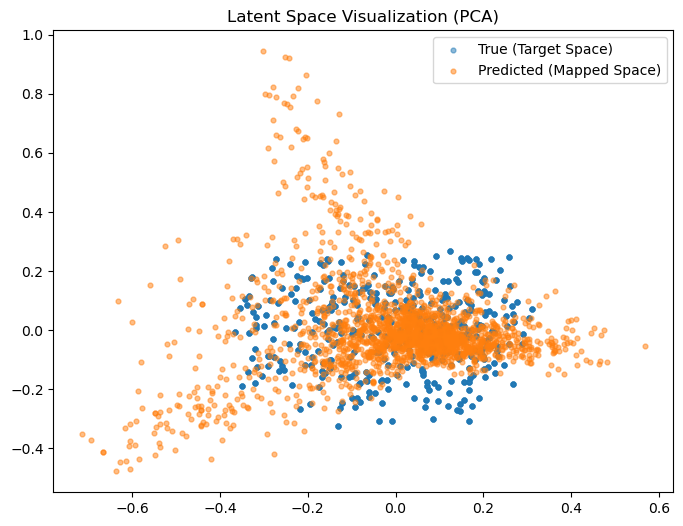

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.003s...
[t-SNE] Computed neighbors for 4000 samples in 0.350s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.408906
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.039673
[t-SNE] KL divergence after 1000 iterations: 0.888053


/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



/Users/valeriosantini/Desktop/Challenge AML/challenge-master/challenge/src/eval/visualize.py:27: UserWarning:

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4422.)



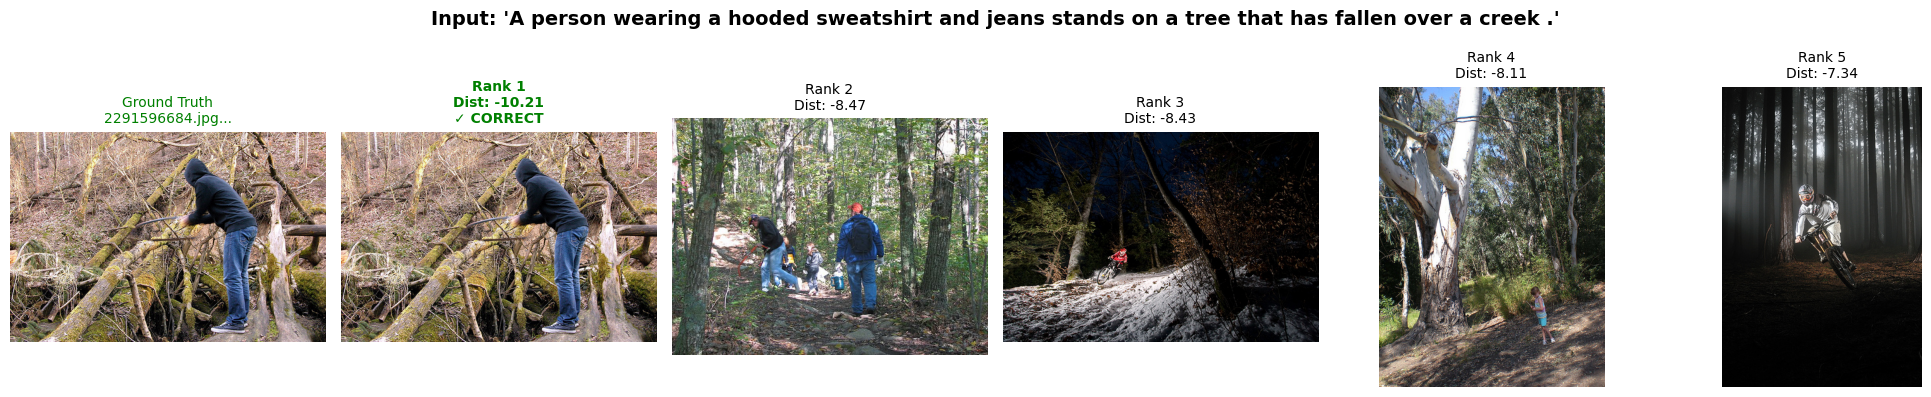

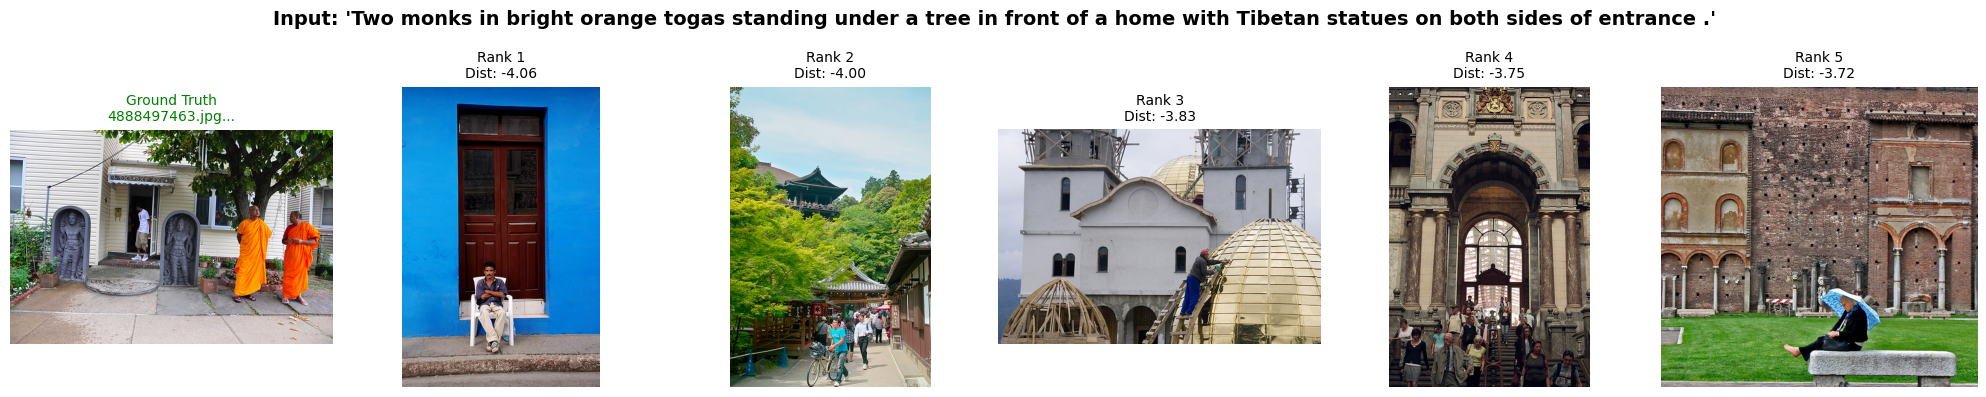

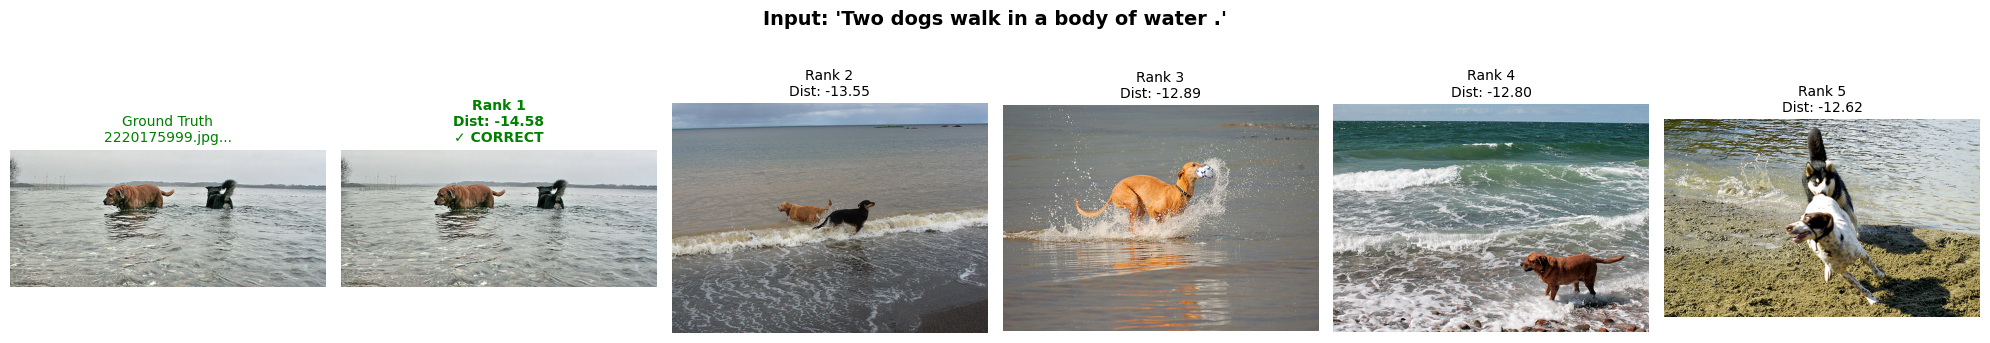

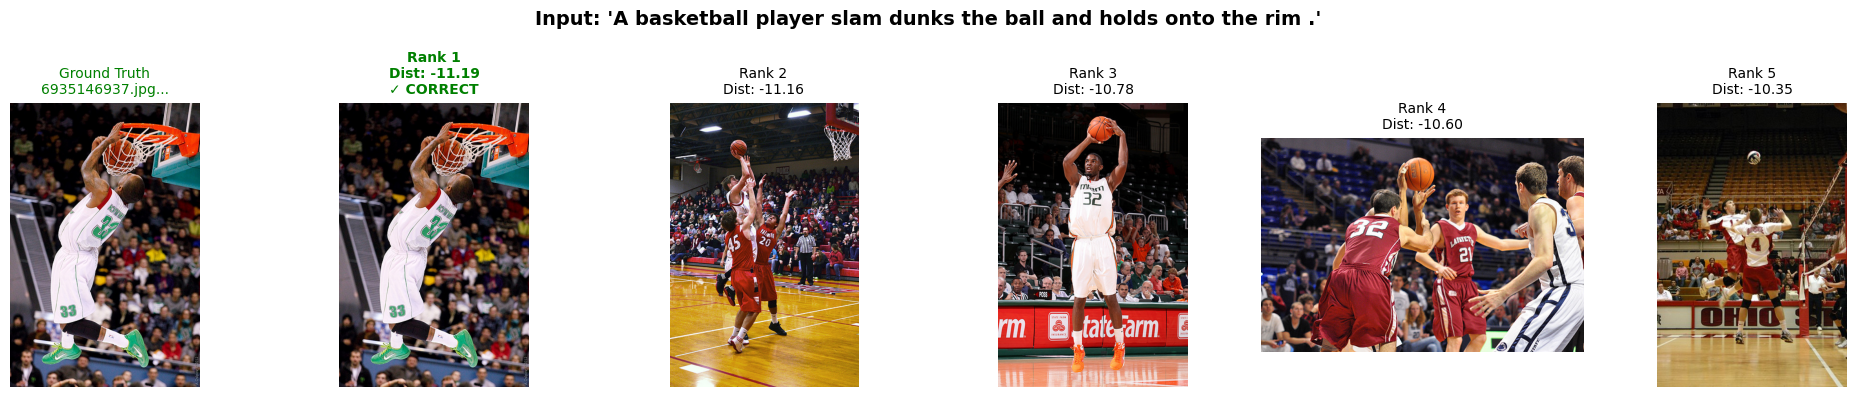

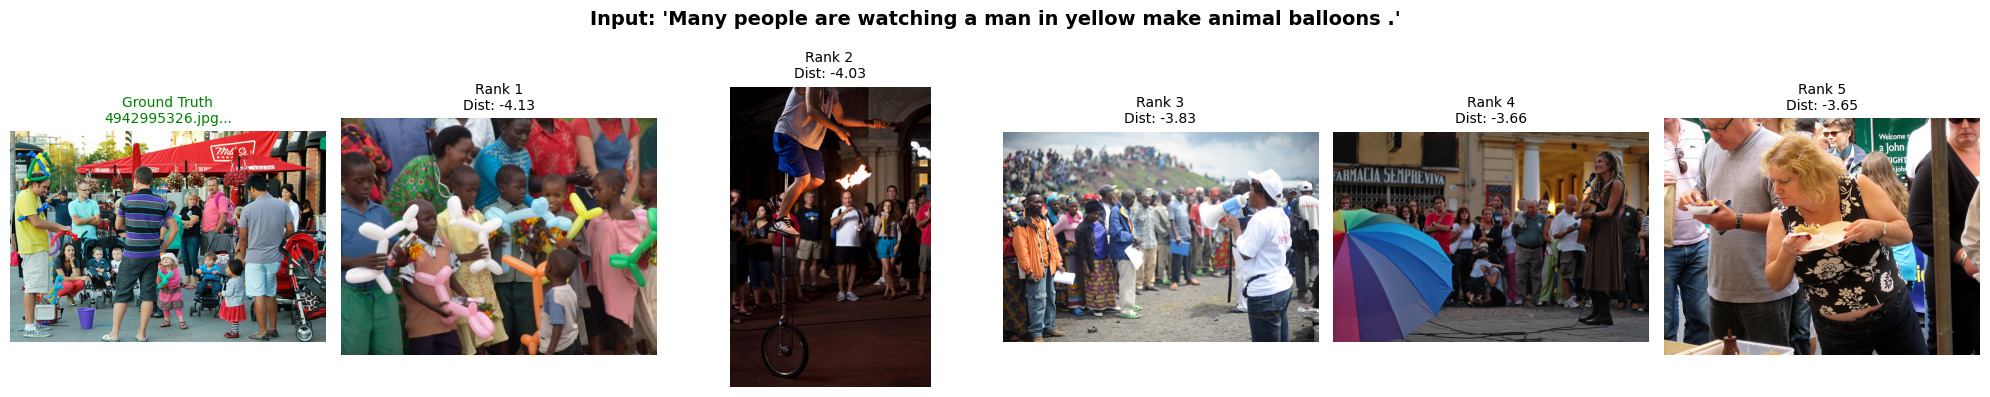

In [16]:
from challenge.src.eval import visualize_retrieval
import numpy as np
import torch

visualize_latent_space(model, X_val, y_val, DEVICE, method="pca")
visualize_tsne(model, X_val, y_val, DEVICE, n_samples=2000)


visualize_latent_space_3d(model, X_val, y_val, DEVICE, n_samples=2000, method="pca")
visualize_latent_space_3d(model, X_val, y_val, DEVICE, n_samples=1000, method="tsne")

val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_VAL_SPLIT])
val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]

# Sample and visualize
for i in range(5):
    idx = np.random.randint(0, 100)
    caption_embd = val_text_embd[idx]
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]

    with torch.no_grad():
        pred_embds = model(caption_embd.to(DEVICE)).cpu()

        visualize_retrieval(
            pred_embds,
            gt_index,
            val_img_file,
            caption_text, val_img_embd, k=5)

## Submission

In [17]:
test_data = load_data("data/test/test.clean.npz")

test_embds = test_data['captions/embeddings']
test_embds = torch.from_numpy(test_embds).float()

with torch.no_grad():
    pred_embds = model(test_embds.to(DEVICE)).cpu()

submission = generate_submission(test_data['captions/ids'], pred_embds, 'submission.csv')
print(f"Model saved to: {MODEL_PATH}")

Generating submission file...
✓ Saved submission to submission.csv
Model saved to: models/mlp_baseline.pth


In [18]:
# --- Evaluate retrieval performance ---
from challenge.src.eval import evaluate_retrieval  # adattalo al tuo path
import numpy as np

model.eval()
with torch.no_grad():
    z_pred_val = model(X_val.to(DEVICE)).cpu()

# ground truth embeddings (target images)
z_img_val = y_val.cpu()
gt_indices = np.arange(len(z_img_val))  # ogni caption ha la sua immagine target

results = evaluate_retrieval(
    translated_embd=z_pred_val,
    image_embd=z_img_val,
    gt_indices=gt_indices,
    max_indices=50,
    batch_size=128
)

print("\n=== Retrieval evaluation (validation set) ===")
for k, v in results.items():
    print(f"{k:>12}: {v:.4f}")



=== Retrieval evaluation (validation set) ===
         mrr: 0.4031
        ndcg: 0.5431
 recall_at_1: 0.1705
 recall_at_3: 0.5115
 recall_at_5: 0.8382
recall_at_10: 0.9390
recall_at_50: 0.9960
     l2_dist: 0.8991
